# Quick Event analysis

Just to check the events and maybe delete some of them we will analyse it a bit

In [33]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable
from pathlib import Path

import lib.util
import lib.data_preparation
import lib.event_detection

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

sns.set_style('darkgrid')
sns.set_context('notebook')

pd.set_option('max_columns', None)

In [34]:
folderpath = Path('data/UAH-DRIVESET-v1/')

In [35]:
df = lib.util.read_parquet_and_prepare(
    filepath=Path(folderpath, 'data_event.parquet'),
    col_reindex=None
)

In [36]:
display(df.head())

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2015-12-11 16:56:19.910,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False,0.0,False,True,NaN,NaN
1,2015-12-11 16:56:20.010,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False,0.1,False,True,NaN,NaN
2,2015-12-11 16:56:20.110,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False,0.1,False,True,NaN,NaN
3,2015-12-11 16:56:20.210,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False,0.1,False,True,NaN,NaN
4,2015-12-11 16:56:20.310,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False,0.1,False,True,NaN,NaN


In [37]:
df.known_divisions

True

I test how to aggregrate with multilple columns and functions and make a util function for it:

"lib.util.agg_multilple()"

In [38]:
gb_corner = df.groupby('corner_event')
extent = lib.util.dask_agg_extent()
largest = lib.util.dask_agg_largest()

gb_corner_dyn = gb_corner[['speed', 'yr', 'gy', 'gx', 'beta']].agg(
    [largest, extent, 'mean', 'max', 'min']
)
gb_corner_meta = gb_corner[['distance', 'dtime']].sum()

corner = gb_corner_dyn.join(gb_corner_meta)
corner = corner.rename(columns=lambda x: '_'.join(x) if isinstance(x, tuple) else x)
display(corner.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,yr_largest,yr_extent,yr_mean,yr_max,yr_min,gy_largest,gy_extent,gy_mean,gy_max,gy_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,beta_largest,beta_extent,beta_mean,beta_max,beta_min,distance,dtime
corner_event,,,,,,,,,,,,,,,,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY10x01,86.583077,0.038020,86.564067,86.583077,86.545057,0.007648,0.015173,0.000002,0.007648,-0.007525,0.228046,0.406663,0.011138,0.228046,-0.178617,-0.457086,0.675834,-0.115359,0.218748,-0.457086,0.227868,0.406610,0.011137,0.227868,-0.178742,206.792471,8.6
12km-D5-AGGRESSIVE-SECONDARY14x01,86.502564,0.018339,86.493395,86.502564,86.484225,-0.010299,0.017345,0.000043,0.007047,-0.010299,0.258344,0.398810,0.063579,0.258344,-0.140466,-0.473250,0.534842,-0.108687,0.061592,-0.473250,0.258046,0.398489,0.063561,0.258046,-0.140443,100.909217,4.2
12km-D5-AGGRESSIVE-SECONDARY15x21,86.479305,0.023259,86.467676,86.479305,86.456046,0.010504,0.015366,0.003182,0.010504,-0.004862,-0.337305,0.605055,-0.022641,0.267750,-0.337305,0.695199,1.324584,-0.081717,0.695199,-0.629384,-0.340742,0.609029,-0.023975,0.268287,-0.340742,127.299967,5.3
12km-D5-AGGRESSIVE-SECONDARY18x01,95.492385,9.092250,91.223206,95.492385,86.400134,-0.080482,0.119790,-0.014043,0.039308,-0.080482,0.923908,1.790601,0.019245,0.923908,-0.866693,-2.011232,3.458723,-0.143905,1.447491,-2.011232,0.933211,1.815672,0.025311,0.933211,-0.882461,1218.806412,48.1
12km-D5-AGGRESSIVE-SECONDARY19x31,93.296176,3.474510,91.710717,93.296176,89.821667,-0.107021,0.157362,-0.010723,0.050341,-0.107021,2.235359,3.236427,-0.062314,2.235359,-1.001068,-1.246269,2.049530,-0.141265,0.803261,-1.246269,2.279198,3.272447,-0.057582,2.279198,-0.993250,1480.092912,58.1


In [39]:
corner = lib.util.agg_multilple(
    df.groupby('corner_event')[['speed', 'yr', 'gy', 'beta', 'gx', 'dtime', 'distance']],
    {('speed', 'yr', 'gy', 'beta', 'gx'):[largest, extent, 'mean', 'max', 'min'],
     ('dtime', 'distance'):'sum'}
).compute()
display(corner.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,yr_largest,yr_extent,yr_mean,yr_max,yr_min,gy_largest,gy_extent,gy_mean,gy_max,gy_min,beta_largest,beta_extent,beta_mean,beta_max,beta_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,dtime,distance
corner_event,,,,,,,,,,,,,,,,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY10x01,86.583077,0.038020,86.564067,86.583077,86.545057,0.007648,0.015173,0.000002,0.007648,-0.007525,0.228046,0.406663,0.011138,0.228046,-0.178617,0.227868,0.406610,0.011137,0.227868,-0.178742,-0.457086,0.675834,-0.115359,0.218748,-0.457086,8.6,206.792471
12km-D5-AGGRESSIVE-SECONDARY14x01,86.502564,0.018339,86.493395,86.502564,86.484225,-0.010299,0.017345,0.000043,0.007047,-0.010299,0.258344,0.398810,0.063579,0.258344,-0.140466,0.258046,0.398489,0.063561,0.258046,-0.140443,-0.473250,0.534842,-0.108687,0.061592,-0.473250,4.2,100.909217
12km-D5-AGGRESSIVE-SECONDARY15x21,86.479305,0.023259,86.467676,86.479305,86.456046,0.010504,0.015366,0.003182,0.010504,-0.004862,-0.337305,0.605055,-0.022641,0.267750,-0.337305,-0.340742,0.609029,-0.023975,0.268287,-0.340742,0.695199,1.324584,-0.081717,0.695199,-0.629384,5.3,127.299967
12km-D5-AGGRESSIVE-SECONDARY18x01,95.492385,9.092250,91.223206,95.492385,86.400134,-0.080482,0.119790,-0.014043,0.039308,-0.080482,0.923908,1.790601,0.019245,0.923908,-0.866693,0.933211,1.815672,0.025311,0.933211,-0.882461,-2.011232,3.458723,-0.143905,1.447491,-2.011232,48.1,1218.806412
12km-D5-AGGRESSIVE-SECONDARY19x31,93.296176,3.474510,91.710717,93.296176,89.821667,-0.107021,0.157362,-0.010723,0.050341,-0.107021,2.235359,3.236427,-0.062314,2.235359,-1.001068,2.279198,3.272447,-0.057582,2.279198,-0.993250,-1.246269,2.049530,-0.141265,0.803261,-1.246269,58.1,1480.092912


In [40]:
straight = lib.util.agg_multilple(
    df.groupby('straight_event')[['speed', 'gx', 'dtime', 'distance']],
    {
        ('speed', 'gx'):[largest, extent, 'mean', 'max', 'min'],
        ('dtime', 'distance'):'sum'
    }
).compute()
display(straight.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,dtime,distance
straight_event,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY1x41,114.130667,7.346667,110.457333,114.130667,106.784000,-1.676185,2.465442,-0.476669,0.789258,-1.676185,7.7,236.359344
12km-D5-AGGRESSIVE-SECONDARY3x71,101.274000,14.873866,89.335650,101.274000,86.400134,-2.011232,3.458723,-0.117794,1.447491,-2.011232,156.3,3878.801101
12km-D5-AGGRESSIVE-SECONDARY5x41,102.852751,16.919915,91.646258,102.852751,85.932836,-1.322494,2.419326,-0.131938,1.096831,-1.322494,124.1,3159.089294
12km-D5-AGGRESSIVE-SECONDARY6x11,113.920712,9.967638,108.936893,113.920712,103.953074,-0.778016,1.429323,-0.114215,0.651307,-0.778016,15.5,468.894507
12km-D5-AGGRESSIVE-SECONDARY7x61,135.474110,34.759349,122.704107,135.474110,100.714761,-1.194212,1.954477,-0.156730,0.760265,-1.194212,56.2,1915.739852


Some corner event statistics

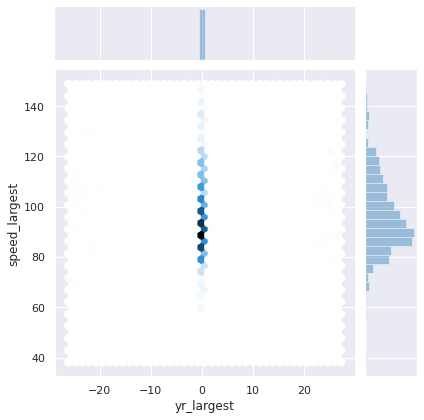

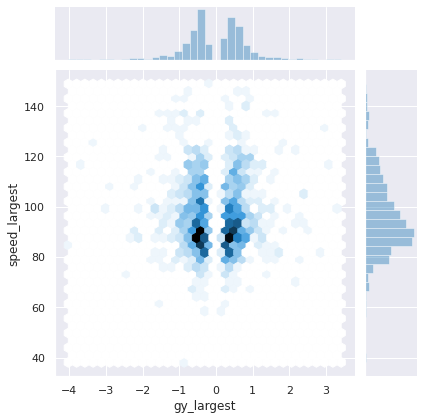

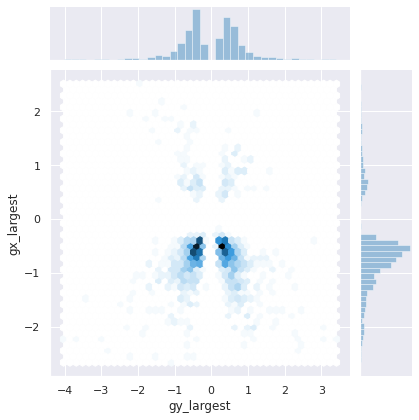

In [41]:
sns.jointplot(x="yr_largest", y="speed_largest", data=corner, kind='hex')
sns.jointplot(x="gy_largest", y="speed_largest", data=corner, kind='hex')
sns.jointplot(x="gy_largest", y="gx_largest", data=corner, kind='hex')

Some straight event statistics

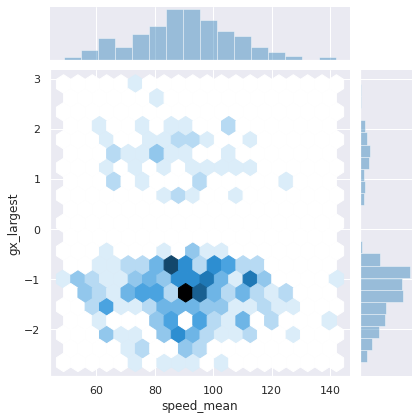

In [42]:
sns.jointplot(x="speed_mean", y="gx_largest", data=straight, kind='hex');

I will compress the data with their change point and trace the average corner event shape in YR

In [43]:
with ProgressBar():
    df_corner_compress = df.map_partitions(
        lambda x: lib.event_detection.change_points_event(x, 'corner_event')
    ).reset_index(drop=True).compute()

display(df_corner_compress.head())

[########################################] | 100% Completed | 10.8s


,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event
0,2015-12-11 16:58:20.010,107.87,40.549820,-3.478303,686.7,6.0,5.0,345.2,0.352,0.0,2.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,102.57,90.0,1.0,primary,2.0,1.0,40.544704,-3.473154,1.716,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.035587,0.132504,-0.08829,-0.001,0.006,-0.012,-1.583377,-0.024248,-0.921950,12km-D5-AGGRESSIVE-SECONDARY,86.583077,-0.000754,0.132821,24.050790,0.055754,-1.828453e+06,2.404845,-0.034256,2.405089,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY10x01,12km-D5-AGGRESSIVE-SECONDARY3x71
1,2015-12-11 16:58:20.510,107.87,40.549890,-3.478392,686.7,6.0,5.0,345.2,0.352,0.0,2.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,102.57,90.0,1.0,primary,2.0,1.0,40.544704,-3.473154,1.716,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.292696,0.228046,0.00981,-0.018,0.013,0.009,-1.584790,-0.023506,-0.922987,12km-D5-AGGRESSIVE-SECONDARY,86.580841,0.000424,0.227868,24.050043,0.095649,3.252944e+06,2.404840,-0.030015,2.405027,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY10x01,12km-D5-AGGRESSIVE-SECONDARY3x71
2,2015-12-11 16:58:20.810,107.87,40.549932,-3.478445,686.7,6.0,5.0,345.2,0.352,0.0,2.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,102.57,90.0,1.0,primary,2.0,1.0,40.544704,-3.473154,1.716,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.208743,0.043896,0.00981,-0.012,0.007,-0.001,-1.582017,-0.021822,-0.923567,12km-D5-AGGRESSIVE-SECONDARY,86.579499,-0.004194,0.045656,24.049853,0.019164,-3.285711e+05,2.404684,-0.038322,2.404990,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY10x01,12km-D5-AGGRESSIVE-SECONDARY3x71
3,2015-12-11 16:58:21.210,107.87,40.549988,-3.478516,686.7,6.0,5.0,345.2,0.352,0.0,2.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,102.57,90.0,1.0,primary,2.0,1.0,40.544704,-3.473154,1.716,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.300392,-0.013852,-0.01962,-0.009,0.005,-0.003,-1.578443,-0.026977,-0.924141,12km-D5-AGGRESSIVE-SECONDARY,86.577710,-0.003290,-0.012471,24.049363,-0.005235,-4.188346e+05,2.404641,-0.038297,2.404946,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY10x01,12km-D5-AGGRESSIVE-SECONDARY3x71
4,2015-12-11 16:58:21.810,107.87,40.550071,-3.478622,686.7,6.0,5.0,345.2,0.352,0.0,2.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,102.57,90.0,1.0,primary,2.0,1.0,40.544704,-3.473154,1.716,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.065624,0.018983,0.10791,0.001,0.014,0.011,-1.576281,-0.029069,-0.925783,12km-D5-AGGRESSIVE-SECONDARY,86.575026,0.000763,0.018663,24.048617,0.007833,1.804872e+06,2.404611,-0.034886,2.404866,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY10x01,12km-D5-AGGRESSIVE-SECONDARY3x71


corner_event
12km-D5-AGGRESSIVE-SECONDARY10x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY14x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY15x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY18x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY19x31    AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D6-AGGRESSIVE-MOTORWAY4x27      AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-AGGRESSIVE-MOTORWAY5x17      AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY1x07          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY2x77          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY3x67          AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 1026, dtype: object

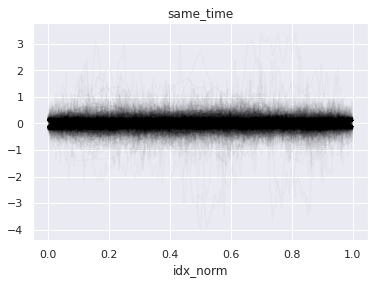

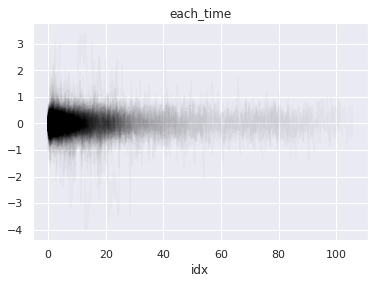

In [44]:
df_corner_plot = df_corner_compress[['gy', 'dtime', 'corner_event']]\
                                    .groupby('corner_event')\
                                    .progress_apply(lib.event_detection.normalize_index, col='dtime')

plt.figure()
df_corner_plot.set_index('idx_norm')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='same_time')

plt.figure()
df_corner_plot.set_index('idx')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='each_time')

corner_event
12km-D5-AGGRESSIVE-SECONDARY10x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY14x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY15x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY18x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY19x31    AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D6-AGGRESSIVE-MOTORWAY4x27      AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-AGGRESSIVE-MOTORWAY5x17      AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY1x07          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY2x77          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY3x67          AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 1026, dtype: object

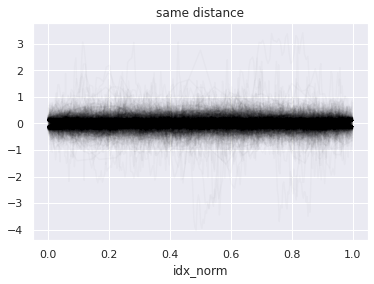

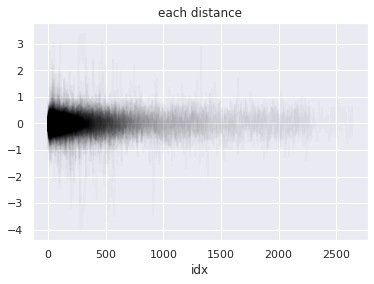

In [45]:
df_corner_plot = df_corner_compress[['gy', 'distance', 'corner_event']]\
                                    .groupby('corner_event')\
                                    .progress_apply(lib.event_detection.normalize_index, col='distance')

plt.figure()
df_corner_plot.set_index('idx_norm')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='same distance')

plt.figure()
df_corner_plot.set_index('idx')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='each distance')

## Application

Let's select some data for the GAN study now

In [46]:
df = lib.util.read_parquet_and_prepare(
    filepath=Path(folderpath, 'data_event.parquet'),
    col_reindex=None
)

In [47]:
df = df.categorize(columns=['corner_event', 'straight_event'])

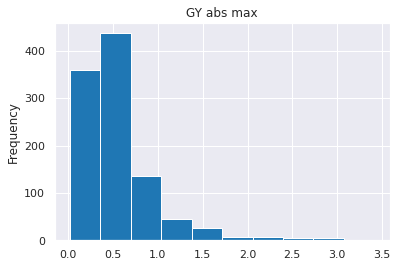

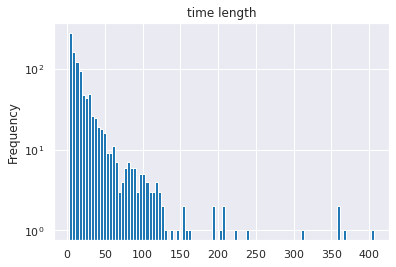

In [48]:
absmax = lib.util.dask_agg_absmax()

corner_feature = df.groupby('corner_event')\
                   .agg({'dtime':'sum','gy':absmax})\
                   .compute()
plt.figure()
corner_feature['gy'].plot(kind='hist', title='GY abs max');
plt.figure()
corner_feature['dtime'].plot(kind='hist', title='time length', logy=True, bins=100);

So from previous 2D plots and the lineplot of all corner event, I select those with more movement and which their length/duration is not an outlier.

'70 / 1026 events selected'

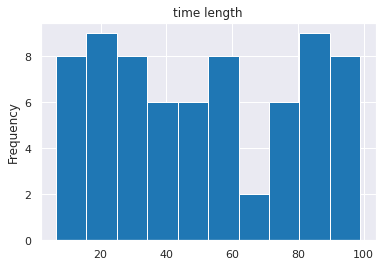

In [49]:
corner_select = (corner_feature['gy'] > 1) & (corner_feature['dtime'] < 100)
display(f'{corner_select.sum()} / {corner_select.shape[0]} events selected')
corner_feature[corner_select]['dtime'].plot(kind='hist', title='time length');

To avoid issues, I converted categorical data into known categorical (with static categories) with "df.categorize"  
see [Dask Categorical](https://docs.dask.org/en/latest/dataframe-categoricals.html)

In [50]:
rem_cat = corner_select.index[~corner_select]

df['corner_select'] = df['corner_event'].cat.remove_categories(rem_cat)

In [51]:
df.head()

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2015-12-11 16:56:19.910,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False,0.0,False,True,NaN,NaN,NaN
1,2015-12-11 16:56:20.010,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False,0.1,False,True,NaN,NaN,NaN
2,2015-12-11 16:56:20.110,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False,0.1,False,True,NaN,NaN,NaN
3,2015-12-11 16:56:20.210,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False,0.1,False,True,NaN,NaN,NaN
4,2015-12-11 16:56:20.310,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False,0.1,False,True,NaN,NaN,NaN


## Compression for each corner event selected

In [52]:
def get_compression(df):

    compression = lib.data_preparation.calculate_change_point(
        df=df.dropna(subset=['corner_select']),
        groupby='corner_select',
        col=['gy', 'gx']
    )
    df = df.join(compression.rename('compression'))
    df['compression'] = df['compression'].fillna(False)

    return df


with ProgressBar():
    df = df.map_partitions(
        get_compression,
        meta=get_compression(df.head())
    ).compute()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  9.3s


In [53]:
df = df.dropna(subset=['corner_select'])
df = df.reset_index(drop=True)
df = df.sort_values(['corner_select', 'timestamp'])

In [54]:
df = df\
    .groupby('corner_select')\
    .progress_apply(lambda x: x.assign(
        time_event=lambda df: df['dtime'].cumsum() - df['dtime'].iloc[0],
        time_event_norm=lambda df: df['time_event'] / df['time_event'].iloc[-1],
        dist_event=lambda df: df['distance'].cumsum() - df['distance'].iloc[0],
        dist_event_norm=lambda df: df['dist_event'] / df['dist_event'].iloc[-1]
    ))

In [55]:
display(df.head())
display(f"{df['corner_select'].unique().shape[0]} events")
display(f"compression: {df['compression'].sum()/df['compression'].shape[0]}%")
display(f'{df.memory_usage(deep=True).sum()/10**6}MB of memory')

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select,compression,time_event,time_event_norm,dist_event,dist_event_norm
432,2015-12-11 16:59:45.310,217.86,40.554346,-3.498567,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.323446,-0.124907,-0.37278,-0.006,0.006,-0.026,-1.578270,-0.077155,-1.641585,12km-D5-AGGRESSIVE-SECONDARY,89.821667,-0.033374,-0.110374,24.950417,-0.048064,-42834.616697,2.493197,-0.072596,2.494257,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.0,0.000000,0.000000,0.000000
433,2015-12-11 16:59:45.410,217.86,40.554350,-3.498596,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.429423,-0.319247,-0.32373,-0.027,-0.006,-0.034,-1.576240,-0.074800,-1.645088,12km-D5-AGGRESSIVE-SECONDARY,89.878333,-0.036633,-0.303285,24.965854,-0.132154,-39048.842688,2.494532,-0.080582,2.495837,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.1,0.001724,2.495837,0.001689
434,2015-12-11 16:59:45.510,217.86,40.554355,-3.498625,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.139842,-0.309281,-0.53955,-0.048,-0.029,-0.043,-1.574005,-0.073217,-1.648911,12km-D5-AGGRESSIVE-SECONDARY,89.935000,-0.036860,-0.293210,24.981617,-0.127844,-38831.938844,2.495966,-0.084773,2.497405,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.2,0.003448,4.993242,0.003379
435,2015-12-11 16:59:45.610,217.86,40.554359,-3.498655,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.105614,-0.167763,-0.08829,-0.011,-0.029,-0.031,-1.569440,-0.073993,-1.652460,12km-D5-AGGRESSIVE-SECONDARY,89.991667,-0.033204,-0.153276,24.997596,-0.066873,-43134.589195,2.497641,-0.081717,2.498979,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,True,0.3,0.005172,7.492221,0.005071
436,2015-12-11 16:59:45.710,217.86,40.554363,-3.498684,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.045568,-0.078230,-0.36297,0.004,-0.019,-0.024,-1.563134,-0.075886,-1.655552,12km-D5-AGGRESSIVE-SECONDARY,90.048333,-0.030044,-0.065113,25.013410,-0.028426,-47702.127756,2.499375,-0.076939,2.500559,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.4,0.006897,9.992780,0.006763


'70 events'

'compression: 0.27773144286905754%'

'24.968855MB of memory'

## Quick Sanity plots

Text(0.5, 1.0, 'compression per event')

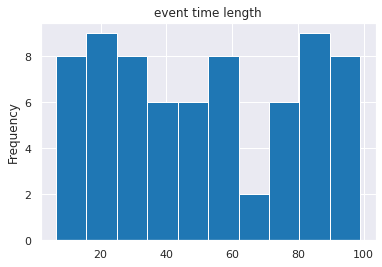

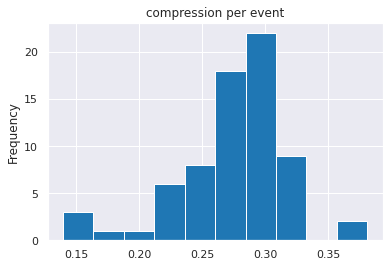

In [56]:
plt.figure()
corner_select_time = df.groupby('corner_select')['dtime'].sum()
corner_select_time.plot(kind='hist')
plt.title('event time length')

plt.figure()
corner_select_time = df.groupby('corner_select')['compression'].agg(lambda x: x.sum() / x.shape[0])
corner_select_time.plot(kind='hist')
plt.title('compression per event')

In [57]:
df_analysis = df.groupby('corner_select')\
                [['gx', 'gy']]\
                .agg(['max', 'min'])\
                .stack()

display(df_analysis.head())

gx        gy
corner_select                                            
12km-D5-AGGRESSIVE-SECONDARY19x31 max  0.803261  2.235359
                                  min -1.246269 -1.001068
12km-D5-AGGRESSIVE-SECONDARY4x91  max  0.789258  1.895936
                                  min -1.676185 -1.332688
13km-D1-DROWSY-SECONDARY11x44     max  1.328707  2.337752

'min & max for GX/GY in each event'

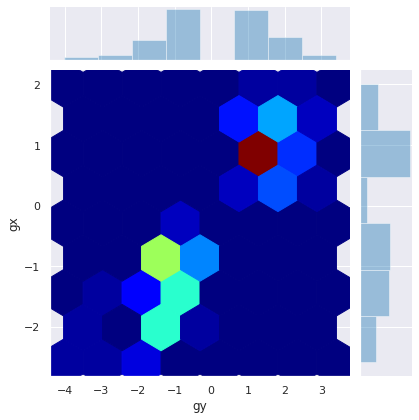

In [58]:
display('min & max for GX/GY in each event')
sns.jointplot('gy', 'gx', df_analysis, kind='hex', cmap='jet')

In [59]:
def absmax(x):
    return abs(max(x))
def extent(x):
    return x.max() - x.min()

df_analysis_speed = df.groupby('corner_select').agg({
    'gy':[absmax, extent],
    'speed':'max'
})
df_analysis_speed.columns = df_analysis_speed.columns.to_flat_index()
df_analysis_speed = df_analysis_speed.rename(columns=lambda x: '_'.join(x))

display(df_analysis_speed.head(1))

,gy_absmax,gy_extent,speed_max
corner_select,,,
12km-D5-AGGRESSIVE-SECONDARY19x31,2.235359,3.236427,93.296176


'speed and 2 values of GY, its extent or its absolute max'

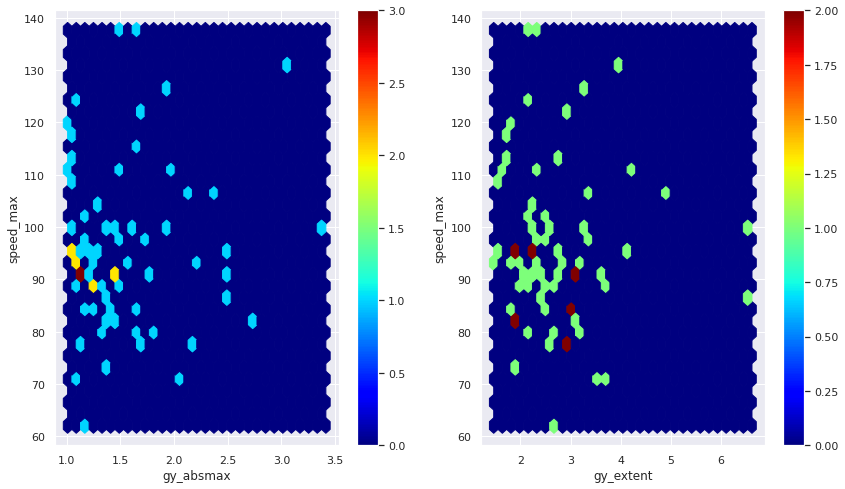

In [60]:
display('speed and 2 values of GY, its extent or its absolute max')

_, axes = plt.subplots(1,2, figsize=(14, 8))
for k, x in enumerate(['gy_absmax', 'gy_extent']):
    df_analysis_speed.plot.hexbin(x=x, y='speed_max', cmap='jet', gridsize=30, ax=axes[k])

The 2D histogram have been encapsulated under:
 - "lib.analysis.plot_gx_gy()"
 - "lib.analysis.plot_gy_speed()"

corner_select
12km-D5-AGGRESSIVE-SECONDARY19x31    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY4x91     AxesSubplot(0.125,0.125;0.775x0.755)
13km-D1-DROWSY-SECONDARY11x44        AxesSubplot(0.125,0.125;0.775x0.755)
13km-D1-DROWSY-SECONDARY1x04         AxesSubplot(0.125,0.125;0.775x0.755)
16km-D1-AGGRESSIVE-SECONDARY2x25     AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D3-DROWSY-MOTORWAY53x09         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D3-DROWSY-MOTORWAY9x69          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D3-NORMAL-MOTORWAY47x.3         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-AGGRESSIVE-MOTORWAY1x17      AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-AGGRESSIVE-MOTORWAY5x17      AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 70, dtype: object

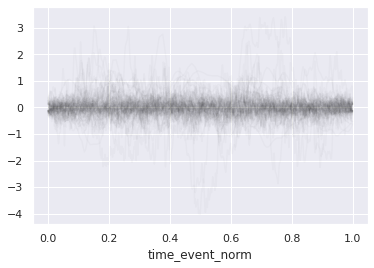

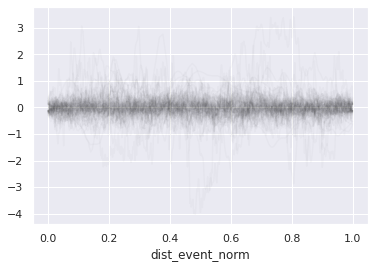

In [61]:
plt.figure()
df.set_index('time_event_norm')\
  .groupby('corner_select')['gy']\
  .plot(style='k', alpha=0.02)

plt.figure()
df.set_index('dist_event_norm')\
  .groupby('corner_select')['gy']\
  .plot(style='k', alpha=0.02)

In [62]:
df = df.groupby('corner_select')\
       .progress_apply(
           lambda x: lib.data_preparation.add_vd_signal(x, x['time_event'], method='integral')
        )
display(df.head())

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select,compression,time_event,time_event_norm,dist_event,dist_event_norm
432,2015-12-11 16:59:45.310,217.86,40.554346,-3.498567,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-3.173005,-1.225342,-3.656972,-0.006,0.006,-0.026,-1.578270,-0.077155,-1.641585,12km-D5-AGGRESSIVE-SECONDARY,89.821667,-0.035029,-1.210088,24.944899,-0.526915,-40810.990519,0.000000,0.000000,0.000000,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.0,0.000000,0.000000,0.000000
433,2015-12-11 16:59:45.410,217.86,40.554350,-3.498596,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-4.212635,-3.131816,-3.175791,-0.027,-0.006,-0.034,-1.576240,-0.074800,-1.645088,12km-D5-AGGRESSIVE-SECONDARY,89.878333,-0.036633,-3.115854,24.929295,-1.357041,-39048.842688,2.489985,-0.165673,2.495837,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.1,0.001724,2.495837,0.001689
434,2015-12-11 16:59:45.510,217.86,40.554355,-3.498625,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-1.371846,-3.034051,-5.292986,-0.048,-0.029,-0.043,-1.574005,-0.073217,-1.648911,12km-D5-AGGRESSIVE-SECONDARY,89.935000,-0.036860,-3.017979,24.947296,-1.315282,-38831.938844,4.978942,-0.370911,4.993242,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.2,0.003448,4.993242,0.003379
435,2015-12-11 16:59:45.610,217.86,40.554359,-3.498655,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,1.036075,-1.645751,-0.866125,-0.011,-0.029,-0.031,-1.569440,-0.073993,-1.652460,12km-D5-AGGRESSIVE-SECONDARY,89.991667,-0.033204,-1.631265,24.987554,-0.711611,-43134.589195,7.471727,-0.544134,7.492221,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,True,0.3,0.005172,7.492221,0.005071
436,2015-12-11 16:59:45.710,217.86,40.554363,-3.498684,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.447022,-0.767433,-3.560736,0.004,-0.019,-0.024,-1.563134,-0.075886,-1.655552,12km-D5-AGGRESSIVE-SECONDARY,90.048333,-0.030044,-0.754317,25.011258,-0.329300,-47702.127756,9.969128,-0.668316,9.992780,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY19x31,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY19x31,False,0.4,0.006897,9.992780,0.006763


In [63]:
df.to_parquet(Path(folderpath, 'data_ready.parquet'))